In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")


random_seed = 176249

Data successfully downloaded


# Clasificación de Orientaciones políticas

En este notebook vamos a tratar de predecir la orientación política del autor de una nota periodística a partir del texto de dicha nota.


El primer paso para ello es leer los datos. En este caso, se tiene un *data frame* con artículos de diarios y la anotación de la orientación política (*left*, *right* o *mainstream*).

In [ ]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
  
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)
train_split

,mainText,orientation
0,#5. Denmark pays students $900 a month to atte...,left
1,Politico POLITICO's must-read briefing on what...,mainstream
2,Dear President Bush. I am interested in buying...,right
3,Just days after the University of North Dakota...,left
4,Washington (CNN)The Senate Wednesday rejected ...,mainstream
...,...,...
1279,The rioters in Charlotte may think they’re pro...,right
1280,"Last October, Hillary Clinton and her top aide...",mainstream
1281,Kansas is bleeding money and jobs and Governor...,left
1282,To cap off a week in which police officers sho...,left


In [ ]:
train_split["mainText"].str.len().mean()

train_split.loc[0,"mainText"]

'#5. Denmark pays students $900 a month to attend college. Thanks to Vermont Senator Bernie Sanders’ proud identification as a Democratic Socialist and allusion to Denmark as an ideal social democracy, Denmark is being discussed throughout the news media. But what few outlets are brave enough to report is that, by almost every measurable standard, Danish socialism runs circles around American capitalism. Here are a few examples:  Denmark has a tremendous social safety net for unemployed workers — any worker who worked at least 52 weeks over a three-year period can qualify to have 90 percent of their original salary paid for, for up to two years. The Danish government also has plentiful training programs for out-of-work Danes. As a result, 73 percent of Danes between 15 and 64 have a paying job, compared to 67 percent of Americans. World Bank data on healthcare costs in developed nations. According to the Organisation for Economic Co-Operation and Development (OECD), the US spends twice

Una práctica muy común para procesar texto es normalizarlo. Algunas técnicas comunes son:
* Eliminar caracteres raros e inusuales
* Convertir todo a minúsculas
* Eliminar palabras que no contienen información relevante (*stop words*)
* *Lemmatization*
* *Stemming*

In [ ]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

train_data, test_data = read_data(test_size=0.2,random_state=random_seed)
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=None)
train_data

,mainText,orientation
0,5 denmark pays students 900 a month to attend ...,left
1,politico politicos mustread briefing on whats ...,mainstream
2,dear president bush i am interested in buying ...,right
3,just days after the university of north dakota...,left
4,washington cnnthe senate wednesday rejected a ...,mainstream
...,...,...
1279,the rioters in charlotte may think theyre prot...,right
1280,last october hillary clinton and her top aides...,mainstream
1281,kansas is bleeding money and jobs and governor...,left
1282,to cap off a week in which police officers sho...,left


Una vez preprocesado, es necesario definir el vocabulario. Es decir, el conjunto de palabras que van a ser consideradas en la extracción de *features*.

100%|██████████| 1284/1284 [00:02<00:00, 583.89it/s]


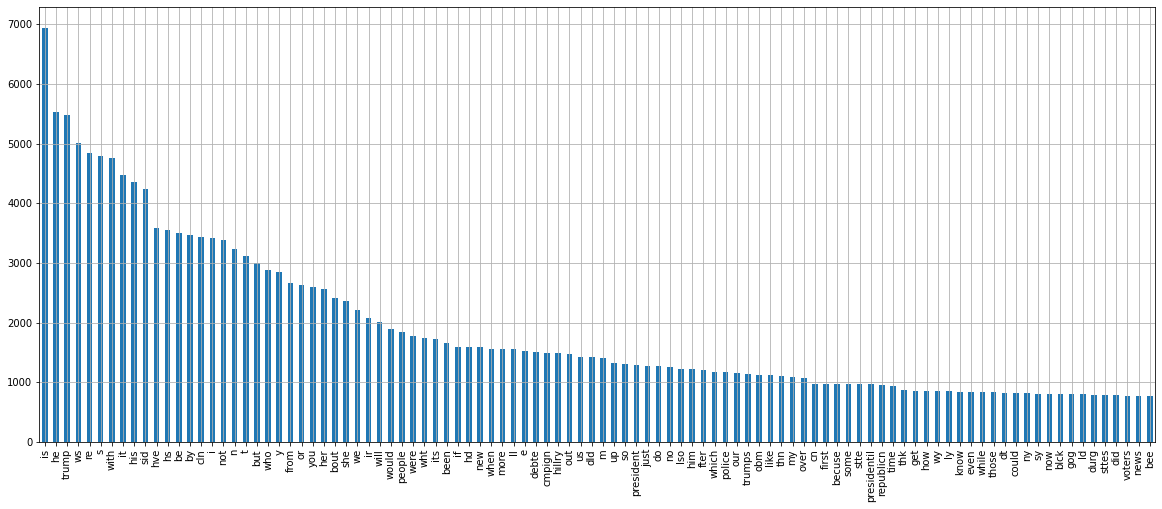

In [ ]:
from nltk import word_tokenize
from collections import defaultdict

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

Una vez hecho esto, es posible vectorizar cada noticia haciendo lo que se conoce como una "bolsa de palabras" (*bag of words*). Es decir, cada documento (noticia) de la base de datos va a consistir en un vecor que contenga en sus componentes la cantidad de veces que aparecieron las palabras del vocabulario en él. 

In [ ]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))

  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X
        

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])

vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

100%|██████████| 320/320 [00:00<00:00, 420.72it/s]


## Baseline

*Show time!* Ahora sí vamos a clasificar noticias. Cuando tenemos una base de datos nueva, una buena práctica es utilizar un modelo ingénuo (*dummy* o *naive*) para evaluarlo. En clasificación es muy común utilizar un modelo que aprende cuál fue la clase más frecuente durante el entrenamiento y elige siempre ésta cuando tiene que realizar una predicción. Esto puede implementarse fácilmente utilizando el objeto `DummyClassifier` de [scikit-learn](https://scikit-learn.org/stable/index.html).

Para evaluar nuestro clasificación vamos a utilizar algunas funciones de la librería `metrics` del mismo paquete. En particular, `plot_confusion_matrix` nos muestra la matriz de confusión del problema de clasificación.

Baseline model:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       166
           1       0.00      0.00      0.00       109
           2       0.00      0.00      0.00        45

    accuracy                           0.52       320
   macro avg       0.17      0.33      0.23       320
weighted avg       0.27      0.52      0.35       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


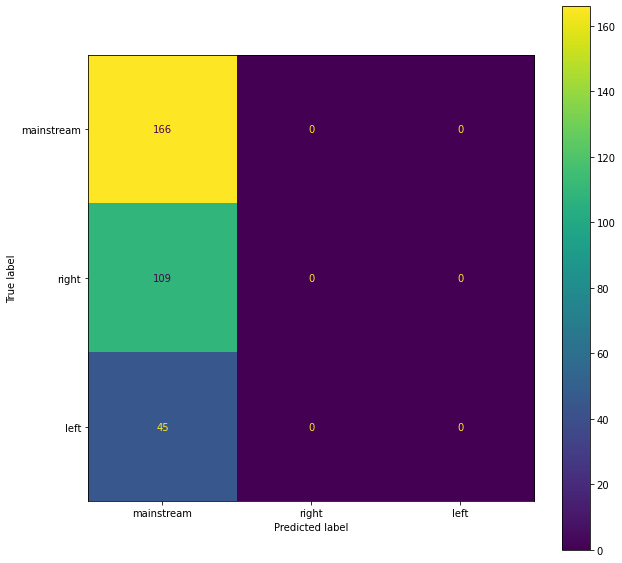

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def show_results(y_true,y_pred):

  # Plot confusion matrix
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  dsp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=["mainstream", "right", "left"],ax=ax)

  # Show Classification report
  print(classification_report(y_true,y_pred))


clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train,y_train)
y_test_pred = clf.predict(X_test)
print("Baseline model:")
show_results(y_test,y_test_pred)

## BOW + Clasificador Softmax

**Tarea 1: Implementar una vectorización por bolsa de palabras y entrenar un clasificador Softmax para clasificar orientaciones políticas. Utilizar exactitud como métrica de evaluación.**

Analizar:
* ¿Funciona mejor el clasificador entrenado que el modelo baseline?
* ¿Cómo influye la cantidad de palabras elegidas? ¿Y la frecuencia mínima de aparición? 
* ¿Qué importancia tienen las stop words en este caso?
* ¿Hay overfitting? ¿Cómo podría reducirlo?

In [ ]:
def get_and_bow_vectorize_data(stop_words=None, max_tokens=10000, min_freq=1):
  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=max_tokens,min_freq=min_freq)
  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})
  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_and_bow_vectorize_data() # X_train son las noticias vectorizadas (bolsa de palabra)
                                                                # y_train son las orientaciones políticas

100%|██████████| 1284/1284 [00:02<00:00, 447.46it/s]


Index(['the', 'to', 'and', 'of', 'a', 'in', 'that', 'is', 'for', 'on',
       ...
       'therapy', 'distress', 'therapeutic', 'diving', 'exercising', 'import',
       'kenneth', 'marched', 'epicenter', 'directions'],
      dtype='object', length=10000)


100%|██████████| 320/320 [00:01<00:00, 311.75it/s]


In [ ]:
# TODO: Implementar Softmax Classifier
import tensorflow as tf
from tensorflow import keras

# Creo el modelo de Keras
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=10000))

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)                             
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
hist = model.fit(x=X_train, y=y_train, batch_size = 1284, epochs=1500,callbacks=[es])


(1284, 10000)
Epoch 1/1500
1/1 [==============================] - 1s 541ms/step - loss: 1.1604 - accuracy: 0.3645
Epoch 2/1500
1/1 [==============================] - 0s 91ms/step - loss: 1.0317 - accuracy: 0.5055
Epoch 3/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.0063 - accuracy: 0.5016
Epoch 4/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.9958 - accuracy: 0.5109
Epoch 5/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.9841 - accuracy: 0.5140
Epoch 6/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.9751 - accuracy: 0.5257
Epoch 7/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.9665 - accuracy: 0.5273
Epoch 8/1500
1/1 [==============================] - 0s 111ms/step - loss: 0.9586 - accuracy: 0.5335
Epoch 9/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.9511 - accuracy: 0.5444
Epoch 10/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.9440 - acc

In [ ]:
predicciones = model.predict(X_test) 
arg_max = np.argmax(predicciones, axis=1)
print("La presición de las predicciones es de ", (np.array(list(y_test)) == arg_max).mean())
# END TODO

La presición de las predicciones es de  0.88125


## Features selection

**Tarea 2: Implementar una vectorización por palabras claves. Es decir, definir un vocabulario inspeccionando las noticias de la base de datos y tratar de hipotetizar qué palabras pueden servir para discriminar entre noticias de izquierda, derecha y *mainstream*. Una  vez hecho esto, implementar nuevamente el clasificador anterior y utilizarlo para predecir en este nuevo escenario.**from nltk import word_tokenize

Hint: para este análisis puede que sea necesario hacer una inspección de los datos y ver qué palabras aparecieron en cada categoría. En este punto, cualquier idea *out-of-the-box* también puede ser útil :)

In [ ]:
def get_data_and_select_keywords(stop_words=None, max_tokens=10000, min_freq=1):
  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  # TODO: implementar selección de palabras claves.
  
  dic= {"democracy": 0, "capitalism": 0, "socialism": 0, "unemployed": 0, "workers": 0, "salary": 0, "americans": 0, 
        "donald trump": 0, "trump": 0, "hillary clinton": 0, "economy": 0, "president": 0, "family": 0, "female": 0, "university": 0,
        "obama": 0, "humanitarian": 0, "crisis": 0, "relationship": 0}
      
  for comment in tqdm(train_data["mainText"]):
    for token in word_tokenize(comment):
      if token in dic:
        dic[token] += 1
  vocab = pd.Series(dic)

  # END TODO

  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_data_and_select_keywords()


100%|██████████| 320/320 [00:00<00:00, 394.29it/s]


In [ ]:
# Creo el modelo de Keras
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=19))

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)                             
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
hist = model.fit(x=X_train, y=y_train, batch_size = 1284, epochs=1500,callbacks=[es])


Epoch 1/1500
1/1 [==============================] - 0s 298ms/step - loss: 1.3565 - accuracy: 0.4860
Epoch 2/1500
1/1 [==============================] - 0s 12ms/step - loss: 1.3546 - accuracy: 0.5389
Epoch 3/1500
1/1 [==============================] - 0s 12ms/step - loss: 1.3527 - accuracy: 0.5389
Epoch 4/1500
1/1 [==============================] - 0s 17ms/step - loss: 1.3508 - accuracy: 0.5389
Epoch 5/1500
1/1 [==============================] - 0s 16ms/step - loss: 1.3489 - accuracy: 0.5389
Epoch 6/1500
1/1 [==============================] - 0s 13ms/step - loss: 1.3470 - accuracy: 0.5382
Epoch 7/1500
1/1 [==============================] - 0s 8ms/step - loss: 1.3451 - accuracy: 0.5382
Epoch 8/1500
1/1 [==============================] - 0s 9ms/step - loss: 1.3433 - accuracy: 0.5389
Epoch 9/1500
1/1 [==============================] - 0s 9ms/step - loss: 1.3414 - accuracy: 0.5389
Epoch 10/1500
1/1 [==============================] - 0s 7ms/step - loss: 1.3395 - accuracy: 0.5389
Epoch 11/150

In [ ]:
predicciones = model.predict(X_test) 
arg_max = np.argmax(predicciones, axis=1)
print("La presición de las predicciones utilizando algunas palabras es de ", (np.array(list(y_test)) == arg_max).mean())

La presición de las predicciones utilizando algunas palabras es de  0.615625
